In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import simweights
import pickle
import os, sys
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import pandas as pd
import tables
import h5py
import math
from scipy.stats import mstats
import matplotlib as mpl
import matplotlib.font_manager as font_manager



In [3]:
sys.path.append("/data/user/tvaneede/GlobalFit/run_taupede_ftp/notebooks")
from weights import *
from utils import *
from files import files
from selections import create_selections
from fonts import *


In [4]:
# version and plotting path
version_0 = "taupede_v5"
files_0 = files[version_0]

version_1 = "taupede_v6"
files_1 = files[version_1]


In [5]:
main_plotting_path = f"/data/user/tvaneede/GlobalFit/run_taupede_ftp/notebooks/output/{version_0}-vs-{version_1}"
os.system(f"mkdir -p {main_plotting_path}")

0

In [6]:
flavors = ["NuTau_E2", "NuTau_E3"]

In [7]:
# open the files
for flavor in flavors:
    files_0[flavor]['hdf_file'] = pd.HDFStore(files_0[flavor]['file_path'],'r')
    files_0[flavor]['variables'] = get_variables( files_0[flavor]['hdf_file'] )
    files_0[flavor] = Append_Weights( files_0[flavor] )

    files_1[flavor]['hdf_file'] = pd.HDFStore(files_1[flavor]['file_path'],'r')
    files_1[flavor]['variables'] = get_variables( files_1[flavor]['hdf_file'] )
    files_1[flavor] = Append_Weights( files_1[flavor] )


In [8]:
keys_to_merge = {
    # "NuE" : ["NuE_E2", "NuE_E3"],
    # "NuMu" : ["NuMu_E2", "NuMu_E3"],
    # "NuTau" : ["NuTau_E2", "NuTau_E3"],
    # "NuAll" : ['NuE', "NuMu", "NuTau"],
    "NuAll" : ["NuTau_E2", "NuTau_E3"],

}

def merge_keys( files ):

    for new_key in keys_to_merge:
        files[new_key] = {}
        files[new_key]['variables'] = {}

        for key in keys_to_merge[new_key]:
            for variable in files[key]['variables']:
                if variable not in files[new_key]['variables']:
                    files[new_key]['variables'][variable] = []
                files[new_key]['variables'][variable].append( pd.Series(files[key]['variables'][variable]) )
        
        for variable in files[new_key]['variables']:
            files[new_key]['variables'][variable] = pd.concat(files[new_key]['variables'][variable])
    return files



In [9]:
files_0 = merge_keys(files_0)
files_1 = merge_keys(files_1)

In [10]:
from selections import create_selections

In [11]:
selections_0 = create_selections( files_0["NuAll"] )
selections_1 = create_selections( files_1["NuAll"] )

In [12]:
from plot_utils import *

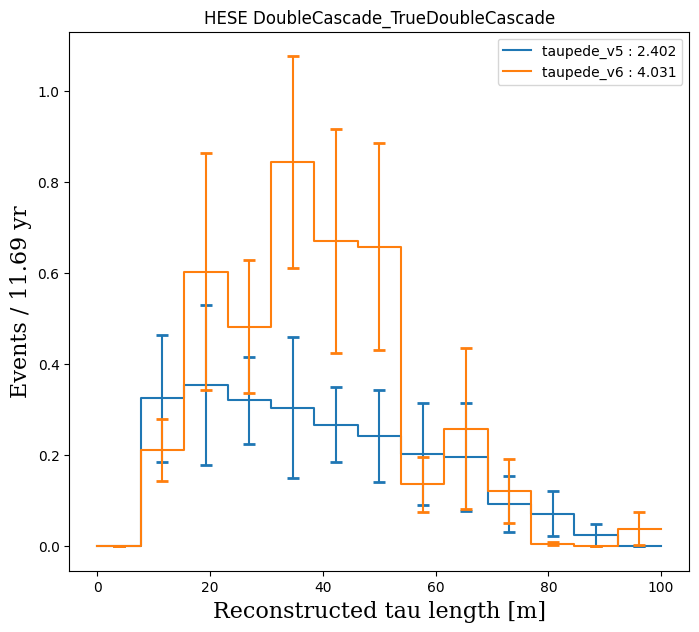

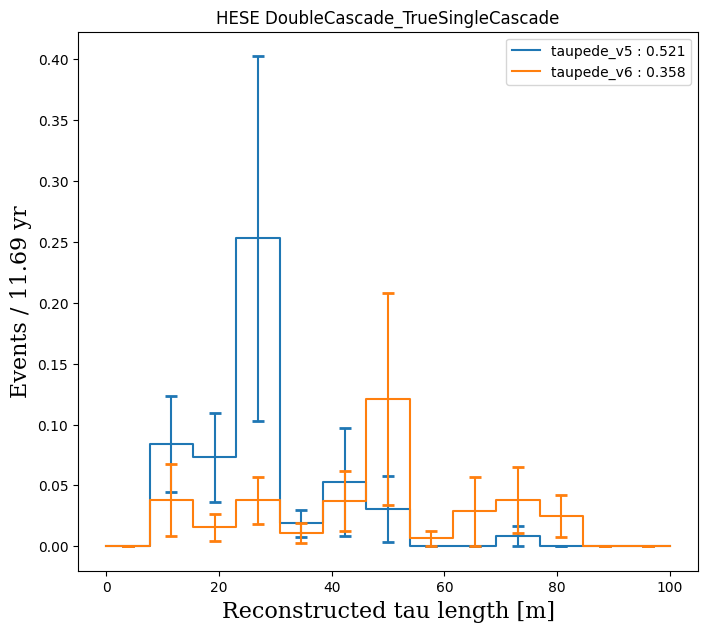

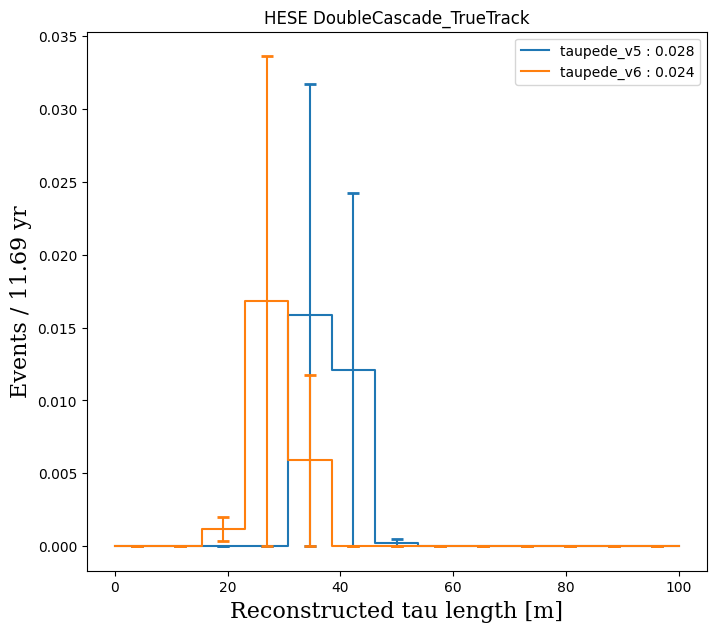

In [13]:
bins = np.linspace(0,100,14)
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

for variable in ["RecoL"]:

    plotting_path = f"{main_plotting_path}/{variable}"
    os.system(f"mkdir -p {plotting_path}")

    for selection_name in ["DoubleCascade_TrueDoubleCascade", "DoubleCascade_TrueSingleCascade", "DoubleCascade_TrueTrack"]:
        
        fig, ax = plt.subplots(1, 1,figsize =(8,7))

        selection_0 = selections_0[selection_name]
        selection_1 = selections_1[selection_name]

        # selection_name = selection_name.split("_")[1]

        y = np.abs(files_0['NuAll']['variables'][variable][ selection_0 ])
        w = files_0['NuAll']['variables']['Weights_Astro'][selection_0]
        hist,hist_err = make_hist_error(samples=y, bins=bins,weights=w*368813893.34)
        label = f"{version_0} : {sum(hist):.3f}"
        plot_hist_errorbar(ax=ax,hist=hist,bins=bins,yerror=hist_err,label=label)
    
        y = np.abs(files_1['NuAll']['variables'][variable][ selection_1 ])
        w = files_1['NuAll']['variables']['Weights_Astro'][selection_1]
        hist,hist_err = make_hist_error(samples=y, bins=bins,weights=w*368813893.34)
        label = f"{version_1} : {sum(hist):.3f}"
        plot_hist_errorbar(ax=ax,hist=hist,bins=bins,yerror=hist_err,label=label)
    

        ax.legend()
        ax.set_ylabel(f"Events / {livetime_yr:.2f} yr",fontdict=font_axis_label)
        ax.set_xlabel("Reconstructed tau length [m]",fontdict=font_axis_label)
        ax.set_title(f"HESE {selection_name}")
        plt.savefig(f"{plotting_path}/{variable}_selection-NehaHESE-{selection_name}.pdf")


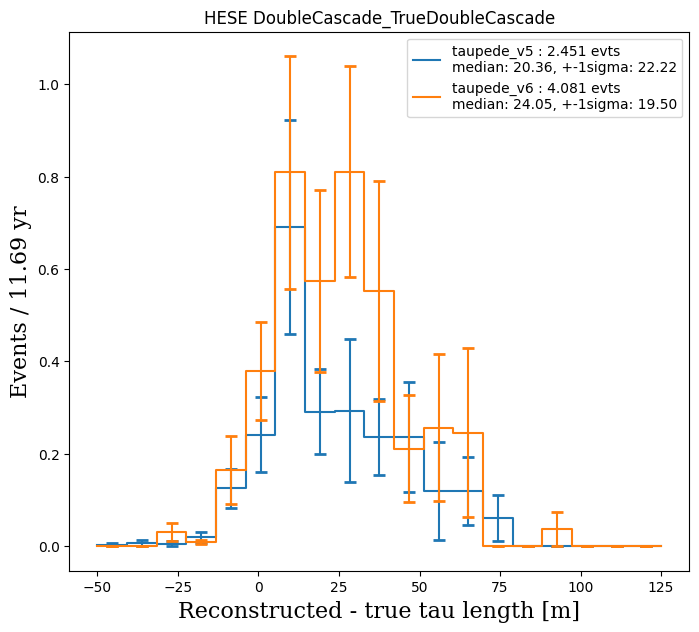

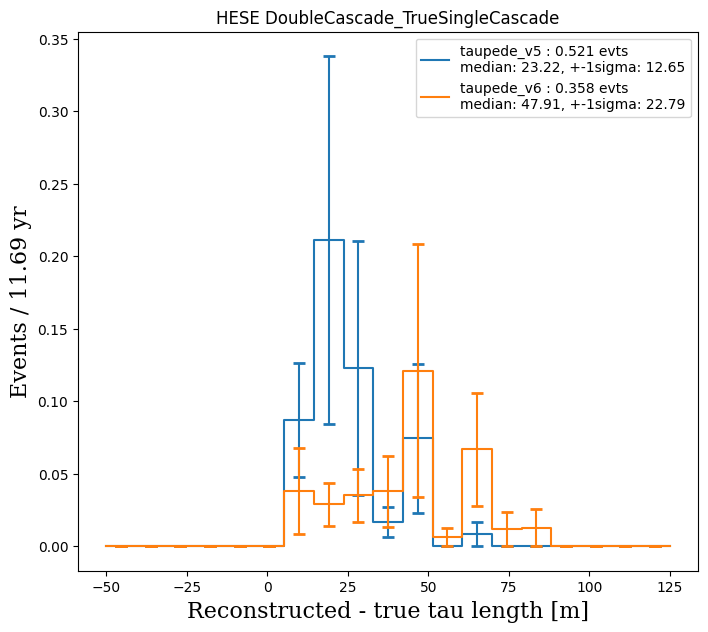

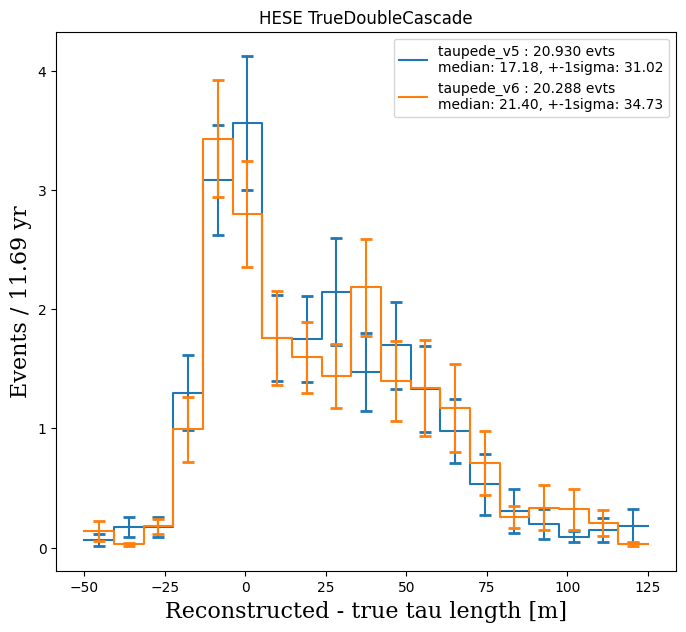

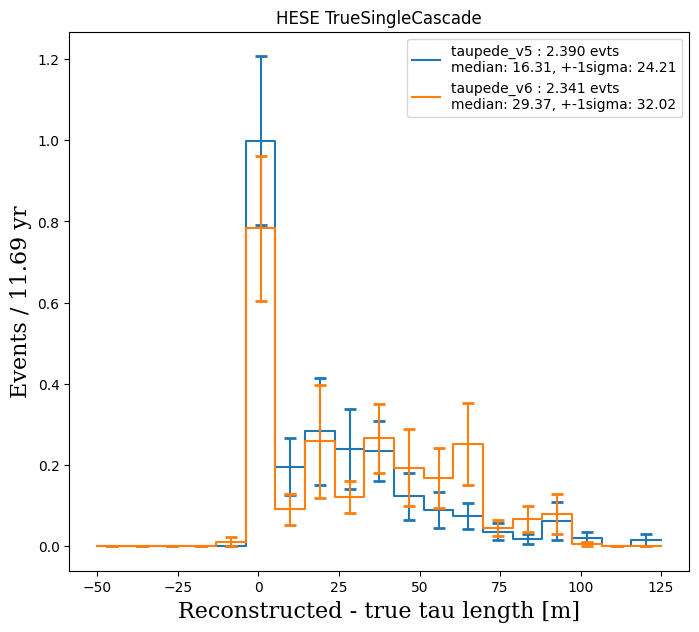

In [15]:
# length resolution
bins = np.linspace(-50,125,20)
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

for variable in ["RecoL"]:

    plotting_path = f"{main_plotting_path}/{variable}_resolution"
    os.system(f"mkdir -p {plotting_path}")

    for selection_name in ["DoubleCascade_TrueDoubleCascade", "DoubleCascade_TrueSingleCascade", "TrueDoubleCascade", "TrueSingleCascade"]:

        fig, ax = plt.subplots(1, 1,figsize =(8,7))

        selection_0 = selections_0[selection_name]
        selection_1 = selections_1[selection_name]

        # selection_name = selection_name.split("_")[1]

        y = np.abs(files_0['NuAll']['variables'][variable][ selection_0 ]) - files_0['NuAll']['variables']['TrueL'][ selection_0 ]
        w = files_0['NuAll']['variables']['Weights_Astro'][selection_0]
        hist,hist_err = make_hist_error(samples=y, bins=bins,weights=w*368813893.34)
        quantiles = weighted_quantile( values=y, quantiles=[0.16,0.5,0.84], sample_weight=w)
        label = f"{version_0} : {sum(hist):.3f} evts\nmedian: {quantiles[1]:.2f}, +-1sigma: {(quantiles[2]-quantiles[0])/2:.2f}"
        plot_hist_errorbar(ax=ax,hist=hist,bins=bins,yerror=hist_err,label=label)

        y = np.abs(files_1['NuAll']['variables'][variable][ selection_1 ]) - files_0['NuAll']['variables']['TrueL'][ selection_1 ]
        w = files_1['NuAll']['variables']['Weights_Astro'][selection_1]
        hist,hist_err = make_hist_error(samples=y, bins=bins,weights=w*368813893.34)
        quantiles = weighted_quantile( values=y, quantiles=[0.16,0.5,0.84], sample_weight=w)
        label = f"{version_1} : {sum(hist):.3f} evts\nmedian: {quantiles[1]:.2f}, +-1sigma: {(quantiles[2]-quantiles[0])/2:.2f}"
        plot_hist_errorbar(ax=ax,hist=hist,bins=bins,yerror=hist_err,label=label)

        ax.legend()
        ax.set_ylabel(f"Events / {livetime_yr:.2f} yr",fontdict=font_axis_label)
        ax.set_xlabel("Reconstructed - true tau length [m]",fontdict=font_axis_label)
        ax.set_title(f"HESE {selection_name}")
        plt.savefig(f"{plotting_path}/{variable}_resolution_selection-NehaHESE-{selection_name}.pdf")


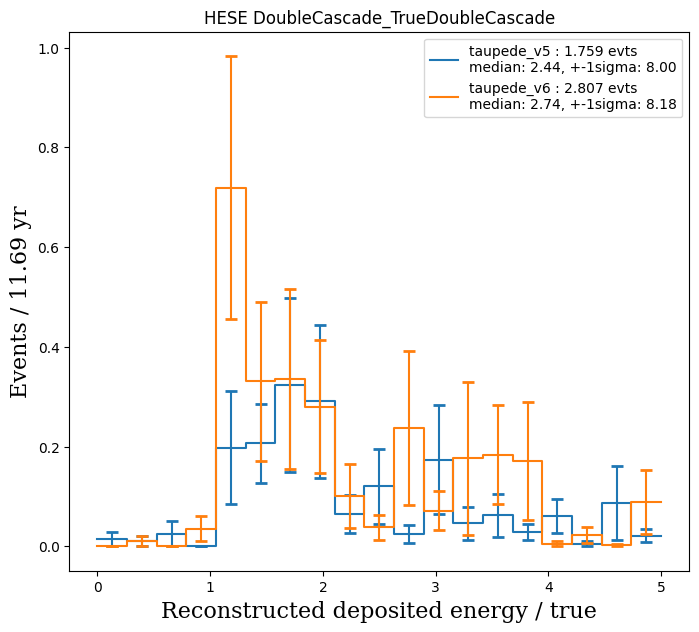

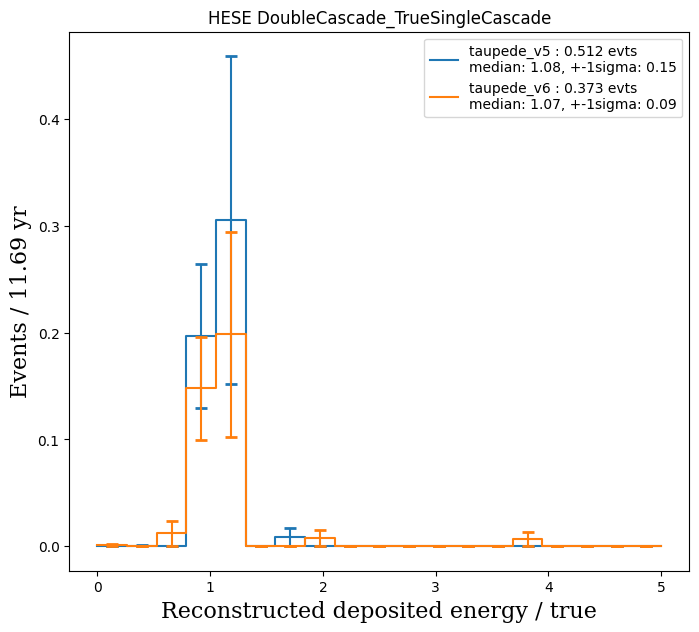

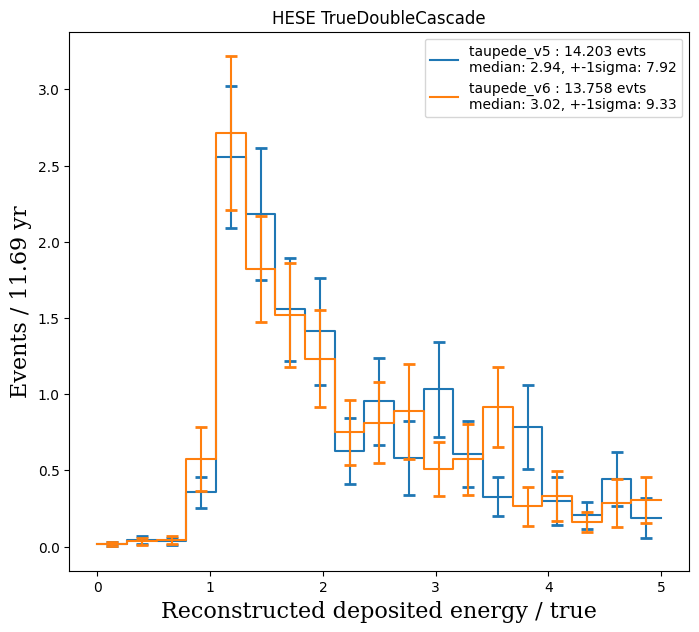

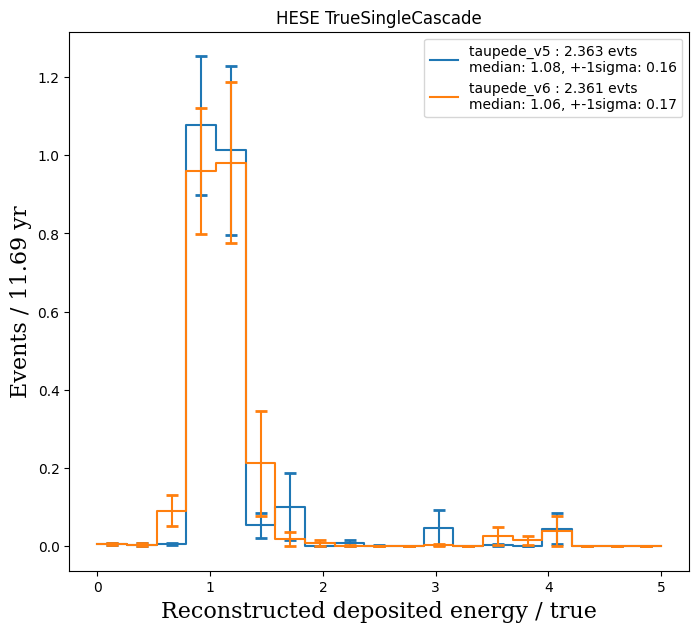

In [21]:
# energy resolution
bins = np.linspace(0,5,20)
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

for variable in ["RecoETot"]:

    plotting_path = f"{main_plotting_path}/{variable}_resolution"
    os.system(f"mkdir -p {plotting_path}")


    for selection_name in ["DoubleCascade_TrueDoubleCascade", "DoubleCascade_TrueSingleCascade", "TrueDoubleCascade", "TrueSingleCascade"]:
        
        fig, ax = plt.subplots(1, 1,figsize =(8,7))

        selection_0 = selections_0[selection_name]
        selection_1 = selections_1[selection_name]

        # selection_name = selection_name.split("_")[1]

        y = np.abs(files_0['NuAll']['variables'][variable][ selection_0 ]) / files_0['NuAll']['variables']['TrueETot'][ selection_0 ]
        w = files_0['NuAll']['variables']['Weights_Astro'][selection_0]
        hist,hist_err = make_hist_error(samples=y, bins=bins,weights=w*368813893.34)
        quantiles = weighted_quantile( values=y, quantiles=[0.16,0.5,0.84], sample_weight=w)
        label = f"{version_0} : {sum(hist):.3f} evts\nmedian: {quantiles[1]:.2f}, +-1sigma: {(quantiles[2]-quantiles[0])/2:.2f}"
        plot_hist_errorbar(ax=ax,hist=hist,bins=bins,yerror=hist_err,label=label)

        y = np.abs(files_1['NuAll']['variables'][variable][ selection_1 ]) / files_1['NuAll']['variables']['TrueETot'][ selection_1 ]
        w = files_1['NuAll']['variables']['Weights_Astro'][selection_1]
        hist,hist_err = make_hist_error(samples=y, bins=bins,weights=w*368813893.34)
        quantiles = weighted_quantile( values=y, quantiles=[0.16,0.5,0.84], sample_weight=w)
        label = f"{version_1} : {sum(hist):.3f} evts\nmedian: {quantiles[1]:.2f}, +-1sigma: {(quantiles[2]-quantiles[0])/2:.2f}"
        plot_hist_errorbar(ax=ax,hist=hist,bins=bins,yerror=hist_err,label=label)

        ax.legend()
        ax.set_ylabel(f"Events / {livetime_yr:.2f} yr",fontdict=font_axis_label)
        ax.set_xlabel("Reconstructed deposited energy / true",fontdict=font_axis_label)
        ax.set_title(f"HESE {selection_name}")
        plt.savefig(f"{plotting_path}/{variable}_resolution_selection-NehaHESE-{selection_name}.pdf")
